### Assignment 1

In [112]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [113]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [114]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2017, 1, 1)

tickers = ['ADBE', 'MSFT']


df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2016-12-23,105.019997,63.240002
2016-12-27,104.980003,63.279999
2016-12-28,103.769997,62.990002
2016-12-29,103.680000,62.900002
2016-12-30,102.949997,62.139999


<Axes: xlabel='Date'>

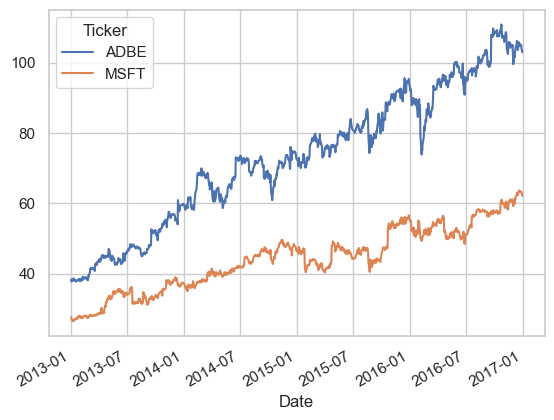

In [115]:
df.describe()
df.plot()

In [116]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1,S2)
pvalue

0.021406400524478036

Hence, the stocks are fairly cointegrated.

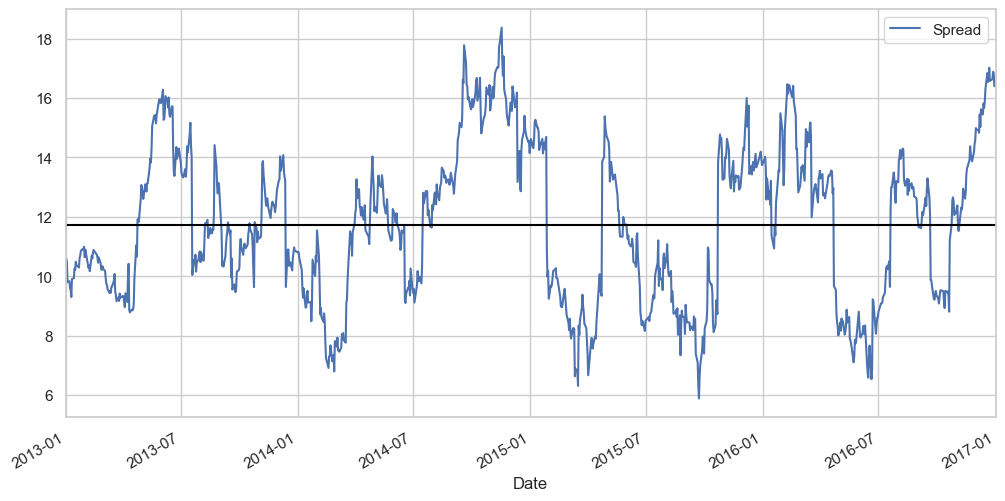

In [117]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2017-01-01')
plt.legend(['Spread'])

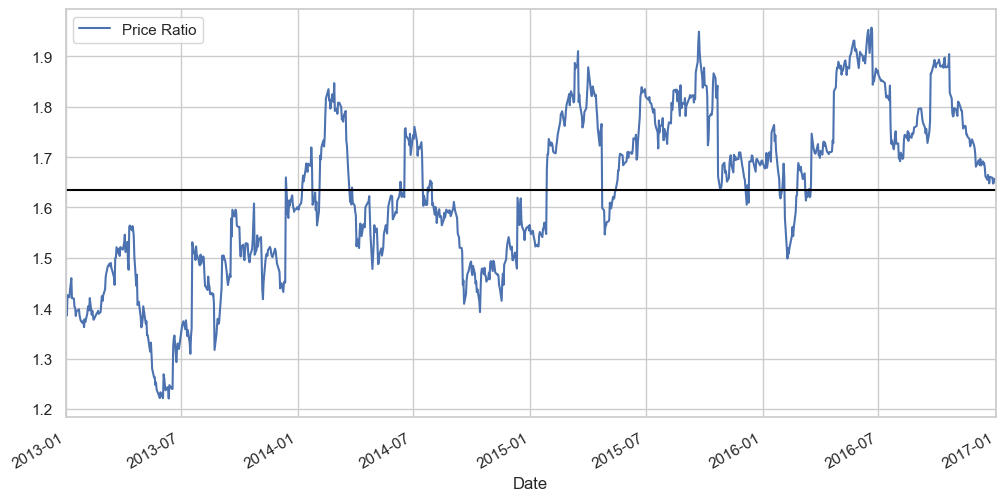

In [118]:
ratio = S1/S2
df['ratio'] = ratio
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2017-01-01')
plt.legend(['Price Ratio'])

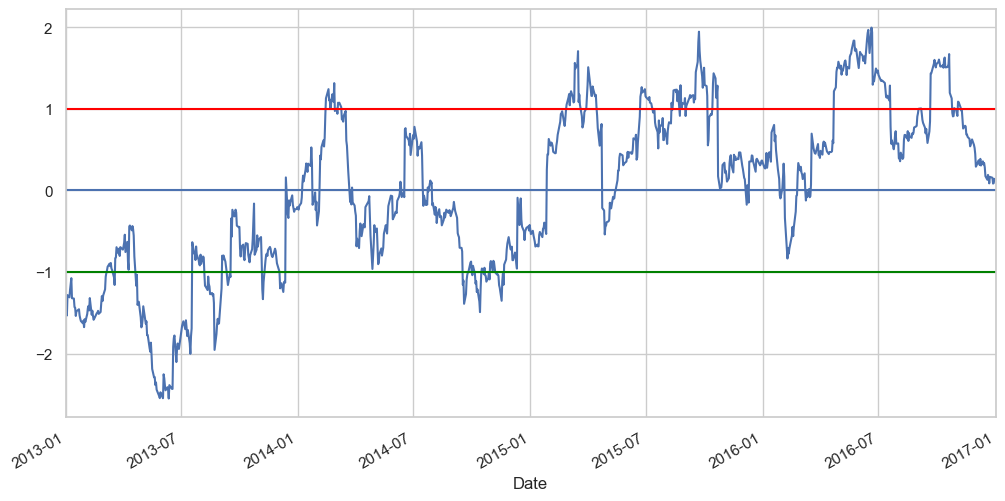

In [119]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2017-01-01')
plt.show()

Defining the features

In [120]:
df['MA_5'] = df['ratio'].rolling(window=5).mean()
df['MA_20'] = df['ratio'].rolling(window=20).mean()
df['MA_30'] = df['ratio'].rolling(window=30).mean()
df['MA_60'] = df['ratio'].rolling(window=60).mean()
df['ROC_5'] = df['MA_5'].pct_change(periods=5)
df['ROC_20'] = df['MA_5'].pct_change(periods=20)
df['Std_20'] = df['ratio'].rolling(window=20).std()
df['Std_60'] = df['ratio'].rolling(window=60).std()
df['Lag_0'] = df['ratio']
df['Lag_1'] = df['ratio'].shift(1)
df['Lag_2'] = df['ratio'].shift(2)
df['Lag_3'] = df['ratio'].shift(3)
df['Lag_4'] = df['ratio'].shift(4)
df['Lag_5'] = df['ratio'].shift(5)
df['target'] = df['ratio'].shift(-1) # next day close price
df.dropna(inplace=True)
df.head()

Ticker,ADBE,MSFT,ratio,MA_5,MA_20,MA_30,MA_60,ROC_5,ROC_20,Std_20,Std_60,Lag_0,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,target
Date,,,,,,,,,,,,,,,,,,
2013-03-28,43.520000,28.610001,1.521146,1.514580,1.482384,1.453620,1.426073,0.025742,0.077379,0.027038,0.046439,1.521146,1.503701,1.518111,1.508878,1.521062,1.500534,1.516253
2013-04-01,43.380001,28.610001,1.516253,1.513618,1.486944,1.458263,1.428208,0.018838,0.071154,0.024423,0.047596,1.516253,1.521146,1.503701,1.518111,1.508878,1.521062,1.522569
2013-04-02,43.849998,28.799999,1.522569,1.516356,1.491208,1.463044,1.430496,0.014173,0.066316,0.022681,0.048783,1.522569,1.516253,1.521146,1.503701,1.518111,1.508878,1.530112
2013-04-03,43.700001,28.559999,1.530112,1.518756,1.494592,1.467714,1.432231,0.006082,0.060176,0.023205,0.050443,1.530112,1.522569,1.516253,1.521146,1.503701,1.518111,1.545804
2013-04-04,44.209999,28.600000,1.545804,1.527177,1.498386,1.472870,1.434303,0.011069,0.059256,0.025086,0.052506,1.545804,1.530112,1.522569,1.516253,1.521146,1.503701,1.511498


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Prepare data
#X = df[['MA_5', 'MA_20', 'MA_60', 'ROC_5', 'ROC_20', 'Std_20', 'Std_60', 'Lag_0', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]
X = df[['Lag_0', 'Lag_1', 'Lag_2', 'MA_5', 'MA_60', 'ROC_5', 'ROC_20']]
y = df['target']

# Sequential Split
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train the model
model = RandomForestRegressor(max_depth=20, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

mae = mean_absolute_error(y_test, X_test['Lag_0'])
print(f"avg diff betwn consecutive vals (benchmark): {mae}")

# Feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
features = [features[i] for i in indices]

# Print the feature ranking
print("\n\nFeature ranking:")
for i in range(len(features)):
    print(f"{features[i]}: {importances[indices[i]]}")

Mean Absolute Error: 0.023872530947208957
avg diff betwn consecutive vals (benchmark): 0.012222581928268078


Feature ranking:
Lag_0: 0.9448156978539097
Lag_1: 0.03211774516374272
MA_60: 0.00588833731780133
ROC_5: 0.004543324043893073
ROC_20: 0.004537962666618802
Lag_2: 0.004076640345390083
MA_5: 0.004020292608644196


Hence training the model to predict the next days price is not helpful. It performs worse than just using the current days price as the prediction for the next day in terms of mean absolute error.

In [122]:
# Evaluate the model on test set
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f"Mean Absolute Error: {mae}")

mae = mean_absolute_error(X_train['Lag_0'], y_train)
print(f"avg diff betwn consecutive vals (benchmark): {mae}")

Mean Absolute Error: 0.007603579744750495
avg diff betwn consecutive vals (benchmark): 0.018638918881963635


On the training data it performs much much better than the benchmark (using the current days price as the prediction for tomorrow). This shows that the model is overfitting the training data. Reducing the features and the depth of the random forests also does not help much and gives similar results.

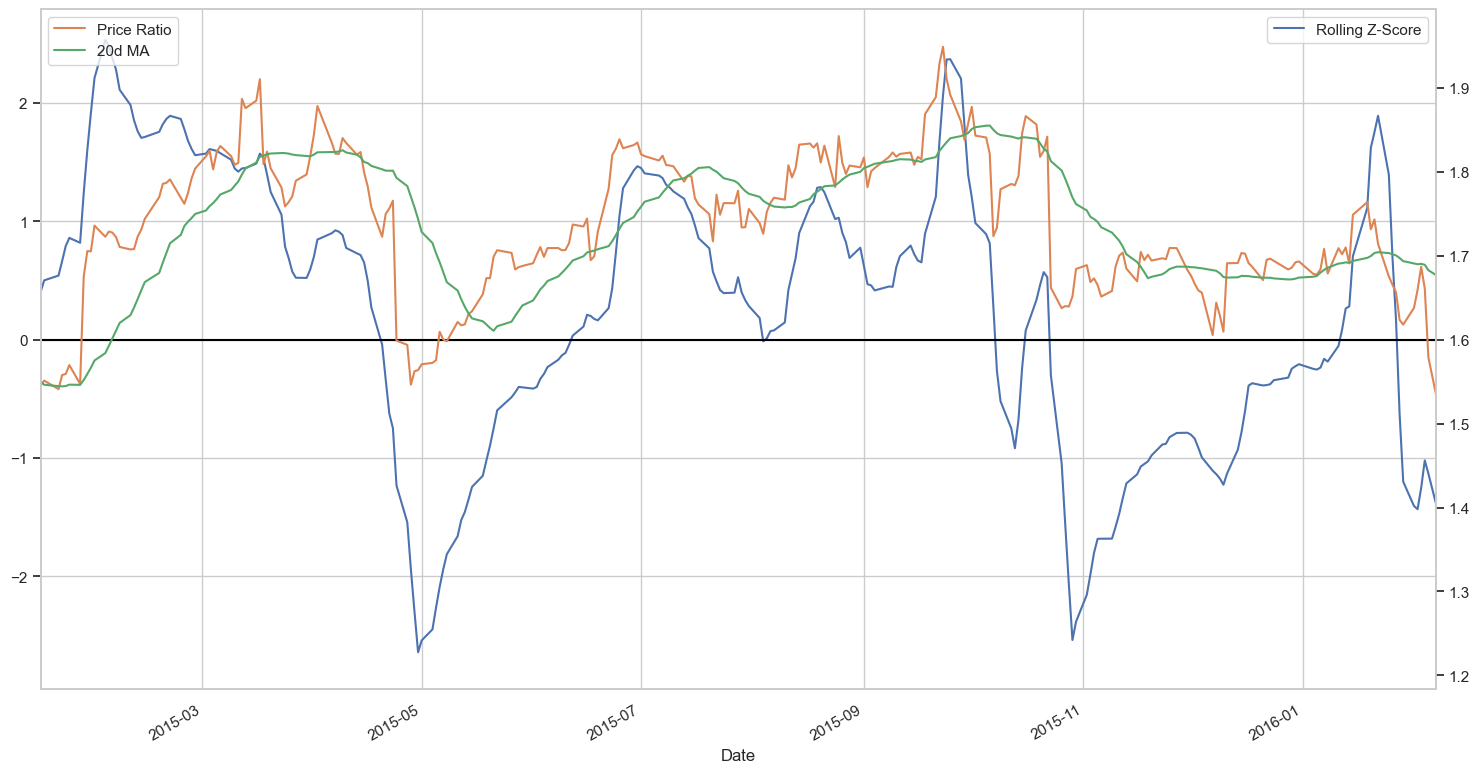

In [123]:
df['rolling_zscore'] = (df['MA_5'] - df['MA_60']) / df['Std_60']
df['rolling_zscore'].plot(figsize=(18,10))
plt.legend(['Rolling Z-Score'])
plt.axhline(0, color='black')
df['ratio'].plot(secondary_y=True)
df['MA_20'].plot(secondary_y=True)
plt.legend(['Price Ratio', '20d MA'], loc='upper left')
plt.xlim('2015-01-15','2016-02-07')
plt.show()

Trying random forest classifier on the price direction movement

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# create a col to store the direction of the price ratio movement. 1 if the price ratio increased, 0 otherwise
df['direction'] = df['target'] > df['ratio'] # direction of the price ratio movement, 1 if the price ratio increased, 0 otherwise
df['direction'] = df['direction'].astype(int)

# Prepare data
X = df[['Lag_0', 'Lag_1', 'Lag_2', 'MA_5', 'MA_60', 'ROC_5', 'ROC_20']]
#X = df[['MA_5', 'MA_20', 'MA_60', 'ROC_5', 'ROC_20', 'Std_20', 'Std_60', 'Lag_0', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]
y = df['direction']
# Sequential Split
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train the model
clf = RandomForestClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model on test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set:")
print(f"Accuracy: {accuracy}")

# evaluate the model on the training set
y_pred = clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Training set:")
print(f"Accuracy: {accuracy}")

Test set:
Accuracy: 0.5052631578947369
Training set:
Accuracy: 0.758575197889182


Here again the model is getting overfitted on the training data. But here the accuracy on the test data is 50.53% and hence is slighty better than random guessing(50%). Trading based on this with a large volume might give returns in the long run.

The following is the implementation of the same on the test data. If model predicts a price ratio increase, we buy the stock, otherwise we sell the stock. Here the returns are not calculated directly i.e. the absolute money returns. In turn the percent change in the price ratio of the two stocks is used as we are trading on the relative value of the stocks.

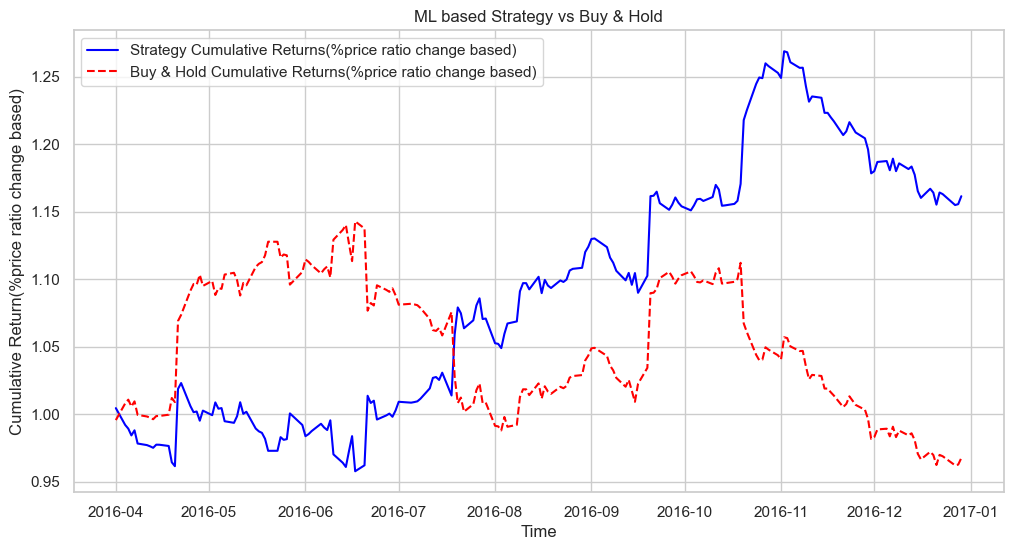

In [125]:
# make trades based on the model's predictions. If the model predicts a price ratio increase, we buy the spread, otherwise we sell the spread
signals = clf.predict(X_test)

# Compute returns based on model predictions
returns = np.where(signals == 1, df['target'].iloc[train_size:].values / df['ratio'].iloc[train_size:].values - 1, 
                    1 - df['target'].iloc[train_size:].values / df['ratio'].iloc[train_size:].values)

# Compute cumulative returns
cumulative_returns = (1 + returns).cumprod()

# Compute benchmark (buy and hold) returns
benchmark_returns = (df['target'].iloc[train_size:] / df['ratio'].iloc[train_size:]).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(df.index[train_size:], cumulative_returns, label='Strategy Cumulative Returns(%price ratio change based)', color='blue')
plt.plot(df.index[train_size:], benchmark_returns, label='Buy & Hold Cumulative Returns(%price ratio change based)', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Cumulative Return(%price ratio change based)')
plt.title('ML based Strategy vs Buy & Hold')
plt.legend()
plt.show()


Here the ml based buying and selling is compared with the hold strategy which is just buying the spread(the ratio) and holding on to it. It basically denotes the returns we were going to get by default. We can see that the initially the ml based trading does worse than the baseline but towards the end it does better. Hence, eventhough not reliable, we can get some returns in the long run with these signals